# Load data

In [2]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [3]:
# Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load train set
train_set = dsets.CIFAR10('../', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# Import Resnet Models

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from copy import deepcopy
from resnet import ResNet18

In [6]:
# Select device
# device = torch.device('cuda')
device = torch.device('cpu')

## Import Resnet model

In [10]:
# Check for model
if os.path.isfile('cifar resnet.pt'):
    # Load saved model
    print('Loading saved model')
    model = torch.load('cifar resnet.pt').to(device)
else:
    print('Model not available')

Loading saved model


## Import surrogate

In [11]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly

In [13]:
# Check for model
if os.path.isfile('cifar surrogate.pt'):
    print('Loading saved surrogate model')
    surr = torch.load('cifar surrogate.pt').to(device)
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

else:
    print('Model not available')

Loading saved surrogate model


## Import Explainer

In [14]:
from unet import UNet
from fastshap import FastSHAP

In [15]:
# Check for model
if os.path.isfile('cifar explainer.pt'):
    print('Loading saved explainer model')
    explainer = torch.load('cifar explainer.pt').to(device)
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

else:
    print('Model not available')

Loading saved explainer model


# Visualize results

In [15]:
import matplotlib.pyplot as plt

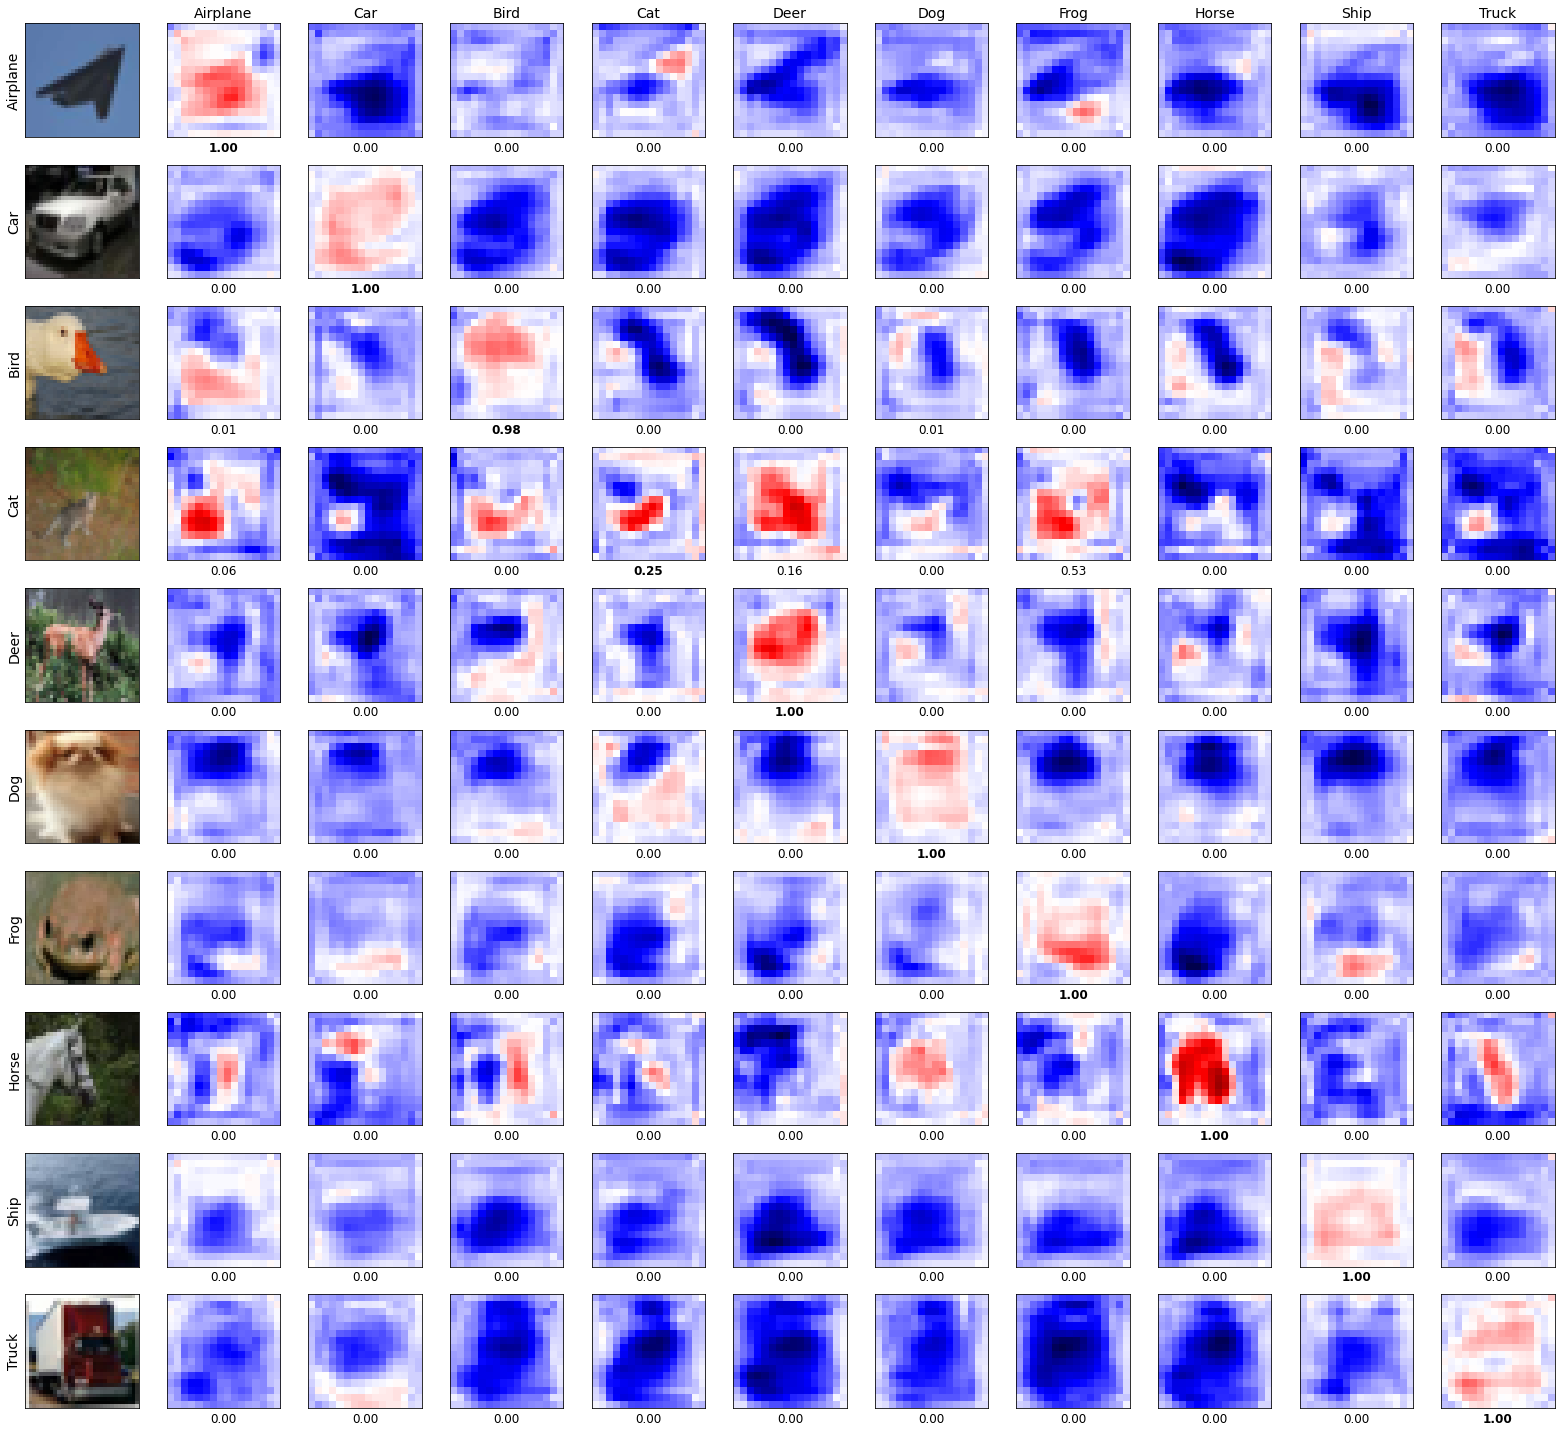

In [16]:
# Select one image from each class
dset = val_set
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
values = fastshap.shap_values(x.to(device))

# Get predictions
pred = surrogate(
    x.to(device),
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()

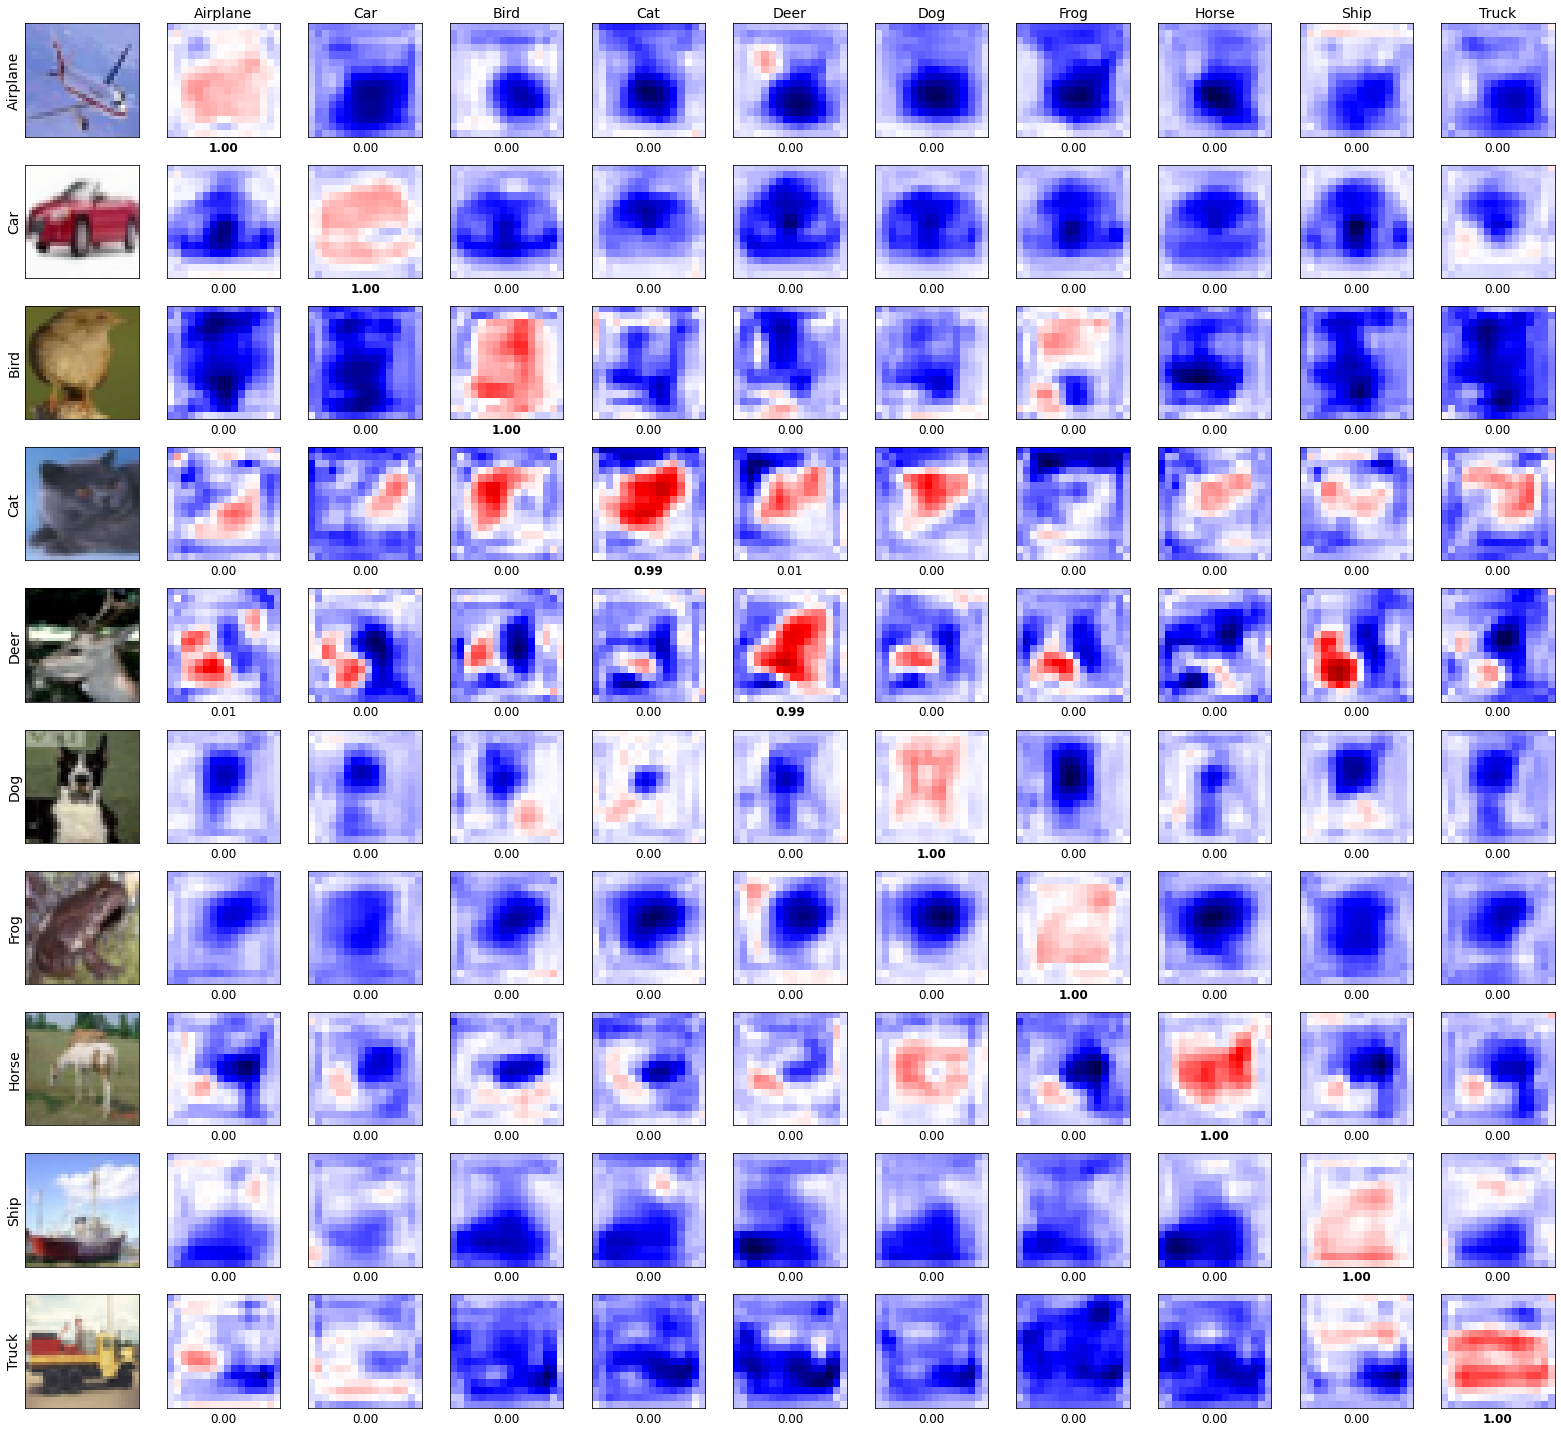

In [82]:
# Select one image from each class
dset = val_set
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
values = fastshap.shap_values(x.to(device))

# Get predictions
pred = surrogate(
    x.to(device),
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()

# Plot individual images and values

In [18]:
def plot_img(x):
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x.numpy() * std + mean    
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    plt.imshow(im, vmin=0, vmax=1)
    plt.show()

In [19]:
def plot_values(value, m):
    plt.imshow(value, cmap='seismic',vmin=-m, vmax=m )

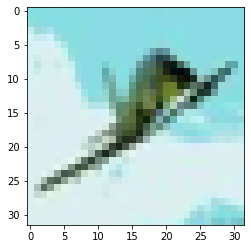

In [20]:
plot_img(x[0])

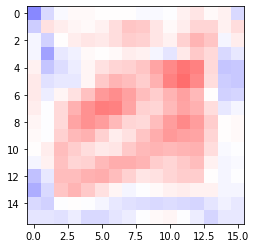

In [21]:
m = np.abs(values[row]).max()
plot_values(values[0][0], m)

In [22]:
type(pred[0])

numpy.ndarray

In [23]:
np.argmax(pred[5])

5

In [24]:
y

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

# Classify Performance

## Create dataframe to store performance info

In [79]:
dset = val_set
dset_size = 10000
targets = np.array(dset.targets)
num_classes = targets.max() + 1
ind = 0
x, y = zip(*[dset[ind]])
x = torch.stack(x)

In [80]:
y[0]

3

Cat


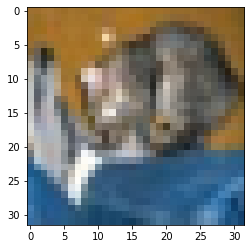

Ship


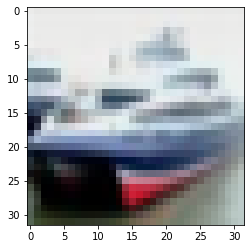

Ship


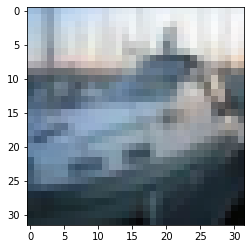

Airplane


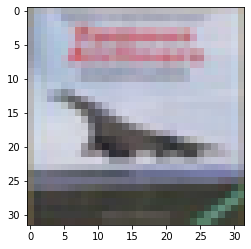

Frog


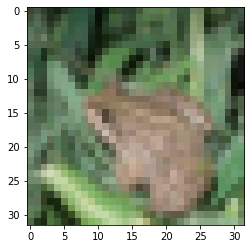

In [81]:
for ind in range(5):
    x, y = zip(*[dset[ind]])
    x = x[0]
    y = y[0]
    print(classes[y])
    plot_img(x)

# Study Model's Performance

In [83]:
x.shape
out = model(x)

In [84]:
out.shape

torch.Size([10, 10])

In [85]:
out_normalized = out.softmax(dim=1)

In [86]:
out_normalized.shape

torch.Size([10, 10])

In [87]:
np.argmax(out_normalized[3].detach().numpy())

3

In [88]:
out_normalized_0 = out_normalized[0].detach()

In [89]:
torch.round(out_normalized_0)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])